In [379]:
from pandas import * 
import os   
import sys 
import numpy as np
import numpy.matlib
import fileinput
import matplotlib.ticker  
import matplotlib.dates
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas.io.sql
import datetime
import numpy as np
from pandas import *
import EAtools as ea
def cm2inch(value):
    return value/2.54
# import EAtools as ea
from db import DB
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
ea.set_options()
ea.ea_report_style()
%pylab inline
%matplotlib inline
from datetime import date, datetime, time, timedelta
pandas.options.mode.use_inf_as_na = True
inputPath='/media/usb/notebooks/Julia/20192020_review/'
carbonPath='/media/P/Roger/'
# db = DB(profile="hallj") 
db = DB(profile="millerr") 
#db = DB(profile="arnoldj") 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'size', 'unique', 'test', 'plotting']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [380]:
gasPriceIncludesCarbon=True #Assume gas price already includes the carbon price, so make sure we don't double count it

### Overview of algorithm and data sources:

### Coal prices

In [381]:
# a pdf can be downloaded from http://www.imining.id/solutions/coal-price-calculator (use the HBA 6322 series starting on page 3)
# This can be converted to csv using https://www.zamzar.com/convert/pdf-to-csv/
# Rename this to 'HBA_coal_price.csv'
# The following code then extracts the HBA 6322 series from the COAL PRICE RECAPITULATION section starting on page 3
# It may be necessary to delete the rows below the end of the COAL PRICE RECAPITULATION table for the code to work

In [382]:
# May have to alter the number of skipped header rows in the following line:
# coalPrice = pd.read_csv(inputPath+'HBA_coal_price_old.csv', skiprows=50)
#coalPrice = pd.read_csv(inputPath+'HBA_coal_price.csv', skiprows=53)

In [383]:
#coalPrice.head(10)

In [384]:
#coalPrice.rename(columns={coalPrice.columns[0]:'date'},inplace=True)
#coalPrice=coalPrice[notna(coalPrice.date)]
#coalPrice['date']= pd.to_datetime(coalPrice['date'],errors='coerce', format="%b-%y")
#coalPrice=coalPrice[notna(coalPrice.date)]
# Already monthly
#coalPrice.set_index('date',inplace=True)
#coalPrice.sort_index(inplace=True)

In [385]:
#coalPrice.head()

In [386]:
#idx=pd.Series(coalPrice.columns.values).str.contains('HBA')
#coalPrice=coalPrice.iloc[:,idx.index[idx]].sort_index()
#coalPrice.rename(columns={coalPrice.columns[0]:'coal'},inplace=True)
#coalPrice.coal=pandas.to_numeric(coalPrice.coal)
#coalPrice.tail()

In [387]:
#coalPrice.to_csv('coal.csv')

In [388]:
coalPrice=pd.read_csv('coal.csv',parse_dates=True,index_col=0,dayfirst=True)
coalPrice.tail()

,coal
date,
2021-07-01,115.35
2021-08-01,130.99
2021-09-01,150.03
2021-10-01,161.63
2021-11-01,215.01


In [389]:
specDownRateFactor=0.24
coalPrice=coalPrice*(1-specDownRateFactor)
coalPrice.tail()

,coal
date,
2021-07-01,87.6660
2021-08-01,99.5524
2021-09-01,114.0228
2021-10-01,122.8388
2021-11-01,163.4076


In [390]:
# Add  US$15/tonne for International Insurance and Freight
coalPrice = coalPrice + 15
coalPrice.tail()

,coal
date,
2021-07-01,102.6660
2021-08-01,114.5524
2021-09-01,129.0228
2021-10-01,137.8388
2021-11-01,178.4076


In [391]:
exchangeRate = pd.read_csv(inputPath+'ExchangeRate.csv', skiprows=6)
# exchangeRate['date']= pd.to_datetime(exchangeRate['date'],errors='coerce', format="%d/%m/%Y")
exchangeRate['date']= pd.to_datetime(exchangeRate['date'],errors='coerce', format="%b-%y")
# Already monthly
exchangeRate.set_index('date',inplace=True)

In [392]:
exchangeRate.tail()

,NZD/USD Exchange Rate
date,
2021-08-01,0.70
2021-09-01,0.71
2021-10-01,0.70
NaT,NaN
NaT,NaN


In [393]:
meanExchangeRate=exchangeRate.loc[exchangeRate.index.map(
    lambda x: (x>= datetime(2014,1,1)) & (x<= datetime(2021,6,1)))].mean().iloc[0]
meanExchangeRate

0.7062222222222222

In [394]:
15/meanExchangeRate/22*10.9 # IF (International Insurance and Freight) cost NZ$/MWh

10.523342296470052

In [395]:
# ax=(15./exchangeRate).plot(figsize=[20,12])
# # ax.legend('IF')None

In [396]:
coalPrice=coalPrice.join(exchangeRate,how='left')

In [397]:
coalPrice.fillna(method='ffill',inplace=True)

In [398]:
coalPrice.tail()

,coal,NZD/USD Exchange Rate
date,,
2021-07-01,102.6660,0.70
2021-08-01,114.5524,0.70
2021-09-01,129.0228,0.71
2021-10-01,137.8388,0.70
2021-11-01,178.4076,0.70


In [399]:
coalPrice.coal=coalPrice.coal/coalPrice['NZD/USD Exchange Rate']
#Add delivery cost of NZD$20/t
coalPrice.coal=coalPrice.coal + 20
coalPrice.drop(columns='NZD/USD Exchange Rate',inplace=True)
coalPrice.tail()

,coal
date,
2021-07-01,166.665714
2021-08-01,183.646286
2021-09-01,201.722254
2021-10-01,216.912571
2021-11-01,274.868000


In [400]:
#Convert $/tonne to $/GJ
heatValue=22. #GJ/tonne
coalPrice.coal=coalPrice.coal/heatValue

In [401]:
coalPrice.tail()

,coal
date,
2021-07-01,7.575714
2021-08-01,8.347558
2021-09-01,9.169193
2021-10-01,9.859662
2021-11-01,12.494000


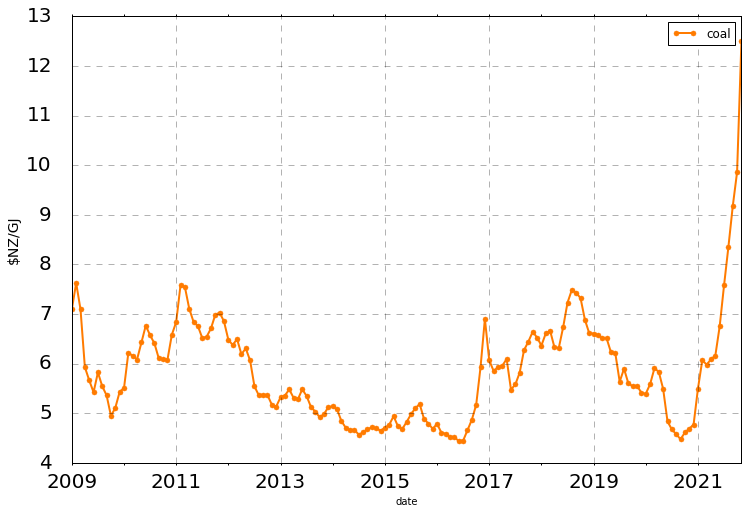

In [402]:
coalPrice.plot(figsize=[12,8],marker='.')
ylabel('$NZ/GJ', fontsize=14)

In [403]:
coalPrice.to_csv('/media/usb/notebooks/Juliaa/HsoTc/coalPrice.csv')

In [404]:
# daily coal for Tuong

In [405]:
dateIndex=pd.DataFrame(index=pd.date_range(start='1/1/2010', end='31/12/2021'))
dateIndex.index.set_names('date', inplace=True)
dateIndex.head()

""
date
2010-01-01
2010-01-02
2010-01-03
2010-01-04
2010-01-05


In [406]:
coalPrice=coalPrice.join(dateIndex,how='right')
coalPrice.fillna(method='ffill',inplace=True)

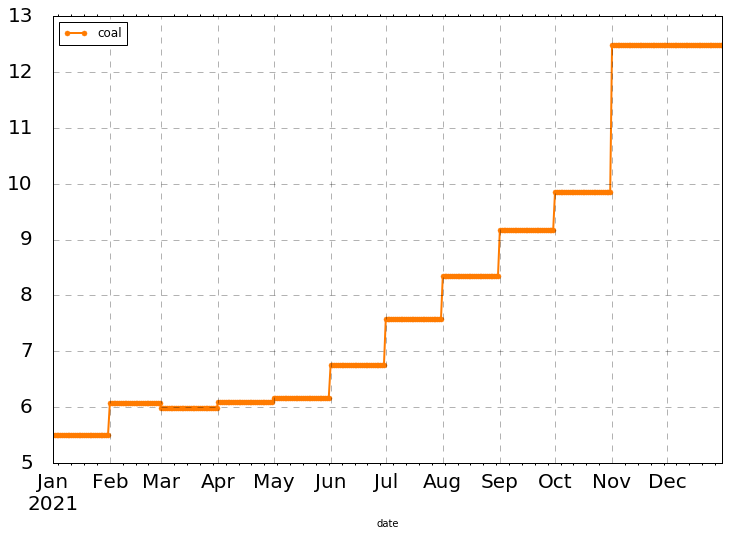

In [407]:
coalPrice[coalPrice.index.map(lambda x: x.year==2021)].plot(figsize=[12,8],marker='.')

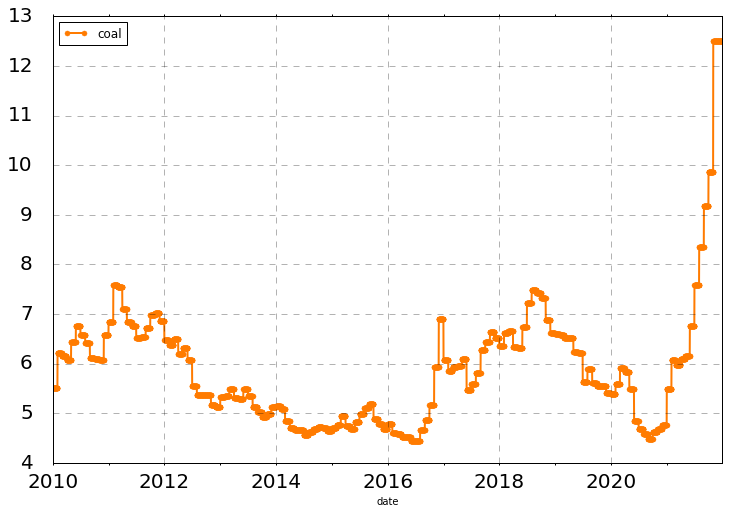

In [408]:
coalPrice.plot(figsize=[12,8],marker='.')

In [409]:
coalPrice.to_csv(carbonPath+'coalPrice.csv')

### Gas spot price

In [410]:
# #use emsTradepoint data instead (see email from David Hunt)
# gasPrice = pd.read_parquet("/media/usb/notebooks/Julia/20192020_review/Gas_VWAP.parquet")
# gasPrice = gasPrice.reset_index()
# gasPrice.head()

In [411]:
#process emsTradepoint file directly:
# gasPrice=pd.read_csv('emsdata.csv',sep='\t',parse_dates=[0], dayfirst=True, names=['date','gas'])
gasPrice=pd.read_csv('emsdata.csv',parse_dates=[0], dayfirst=True) #it's now comma delimited with headings
gasPrice.replace(regex=r'\N',value=NaN,inplace=True)
gasPrice.fillna(method='ffill',inplace=True)
gasPrice.fillna(method='bfill',inplace=True)
gasPrice.gas=pd.to_numeric(gasPrice.gas)
gasPriceDaily=gasPrice.set_index('date')

In [412]:
gasPriceDaily.tail()

,gas
date,
2021-10-28,11.1731
2021-10-29,11.1042
2021-10-30,10.8951
2021-10-31,10.5844
2021-11-01,12.1712


In [413]:
gasPriceDaily.head()

,gas
date,
2013-10-24,4.5
2013-10-25,4.5
2013-10-26,4.5
2013-10-27,4.5
2013-10-28,4.5


In [414]:
# gasPriceDaily.tail(130).plot(figsize=[20,12],marker='.')

In [415]:
# Convert to monthly 
gasPrice['date'] = gasPrice.date.map(lambda x: pd.Period(x, freq='M').to_timestamp())

In [416]:
gasPrice.tail()

,date,gas
2926,2021-10-01,11.1731
2927,2021-10-01,11.1042
2928,2021-10-01,10.8951
2929,2021-10-01,10.5844
2930,2021-11-01,12.1712


In [417]:
gasPrice.set_index('date',inplace=True)
gasPrice=gasPrice.groupby('date').mean()

In [418]:
gasPrice.tail()

,gas
date,
2021-07-01,18.483329
2021-08-01,14.587645
2021-09-01,12.392983
2021-10-01,11.295710
2021-11-01,12.171200


In [419]:
#gasPrice = pd.read_csv(inputPath+'bgix-prices-1627270878.csv',parse_dates=[0])
# Convert to monthly 
#gasPrice['date'] = gasPrice.date.map(lambda x: pd.Period(x, freq='M').to_timestamp())
#gasPrice.set_index('date',inplace=True)
#gasPrice.sort_index(inplace=True)
#gasPrice=DataFrame(gasPrice['amp'])
#gasPrice.rename(columns={'amp':'gas'},inplace=True)
#gasPrice=gasPrice.groupby('date').mean()

In [420]:
#gasPrice.tail()

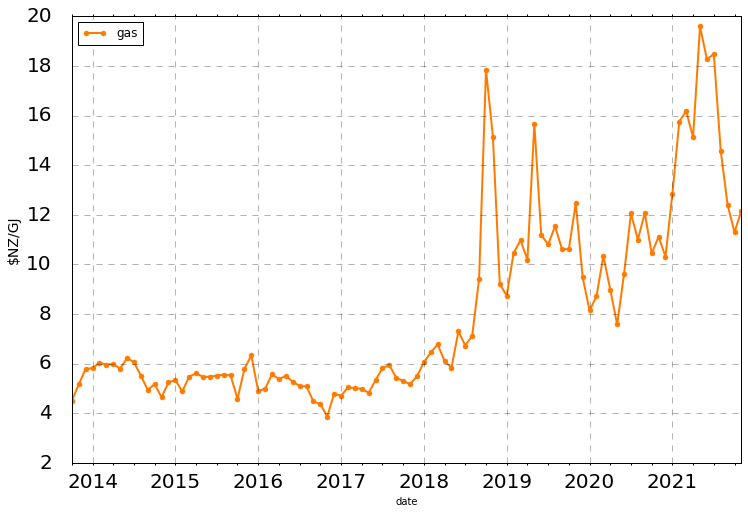

In [421]:
gasPrice.plot(figsize=[12,8],marker='.')
ylabel('$NZ/GJ', fontsize=14)

### Carbon Price

In [527]:
# # Go to https://icapcarbonaction.com/en/ets-prices
# # Select 'NZ ETS' from the 'Systems' drop down menu
# # Click 'Download Data'
# # This data source is updated quarterly
# # Data is already in NZD
# # Non-std csv formatting requires special parsing as follows:

# # May have to change returned cols or make it smarter (search for correct column) if columns change in future
# carbonPrice = pd.read_csv('icap-graph-data-19-03-2019.csv',sep=';',usecols=[0,54,55,56,57,58,59],header=4,parse_dates=[0],
#                           dayfirst=True)
carbonPrice = pd.read_csv('icap-graph-data-19-03-2019.csv',sep=';',usecols=[0,54],header=4,parse_dates=[0],
                          dayfirst=True)

In [528]:
carbonPrice.dtypes

Date                       datetime64[ns]
Domestic Currency (NZD)            object
dtype: object

In [529]:
carbonPrice.tail()

,Date,Domestic Currency (NZD)
6112,2021-09-26,NaN
6113,2021-09-27,"64,4"
6114,2021-09-28,"63,6"
6115,2021-09-29,64
6116,2021-09-30,"64,5"


In [530]:
# for i in range(1,6):
for i in [1]:
    col=carbonPrice.columns[i]
    carbonPrice[col]=carbonPrice[col].str.replace(',', '.', regex=False)
    carbonPrice[col]=pd.to_numeric(carbonPrice[col])

In [531]:
carbonPrice.tail(10)

,Date,Domestic Currency (NZD)
6107,2021-09-21,64.5
6108,2021-09-22,64.5
6109,2021-09-23,64.5
6110,2021-09-24,64.5
6111,2021-09-25,NaN
6112,2021-09-26,NaN
6113,2021-09-27,64.4
6114,2021-09-28,63.6
6115,2021-09-29,64.0
6116,2021-09-30,64.5


In [532]:
carbonPrice.dtypes

Date                       datetime64[ns]
Domestic Currency (NZD)           float64
dtype: object

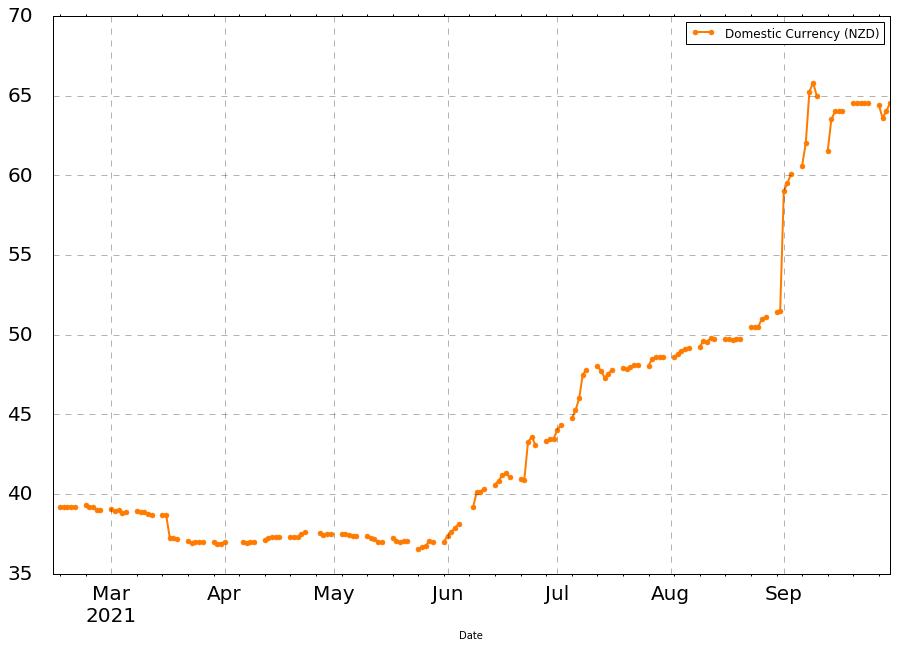

In [533]:
carbonPrice.set_index('Date').tail(230).plot(marker='.',figsize=[15,10])

In [534]:
# carbonPrice.set_index('Date').iloc[:,[1,3,5]].tail(230).plot(marker='.',figsize=[15,10])

In [535]:
carbonPrice.rename(columns={'Date':'date',carbonPrice.columns[1]:'carbon'},inplace=True)
# carbonPrice.carbon=carbonPrice.carbon.str.replace(',', '.', regex=False)
carbonPrice=carbonPrice[notna(carbonPrice.carbon)].iloc[:,[0,1]]
# carbonPrice.carbon=pd.to_numeric(carbonPrice.carbon)

In [536]:
carbonPrice.tail(10)

,date,carbon
6103,2021-09-17,64.0
6106,2021-09-20,64.5
6107,2021-09-21,64.5
6108,2021-09-22,64.5
6109,2021-09-23,64.5
6110,2021-09-24,64.5
6113,2021-09-27,64.4
6114,2021-09-28,63.6
6115,2021-09-29,64.0
6116,2021-09-30,64.5


#### Merge in Phil's "official" carbon price data where available

In [432]:
philCarbon=pd.read_csv(carbonPath+'PhilCarbonPrice.csv',usecols=[0,1],parse_dates=[0],dayfirst=True)#,index_col=0)
philCarbon.rename(columns={'Daily VWAP':'carbon','Date':'date'},inplace=True)
philCarbon=philCarbon[philCarbon.carbon!=0]
philCarbon.head()

,date,carbon
114,2021-02-24,40.00
128,2021-03-10,38.95
158,2021-04-09,39.00
162,2021-04-13,39.00
203,2021-05-24,41.15


In [514]:
philCarbon.tail()

,date,carbon
316,2021-09-14,62.0000
319,2021-09-17,66.0000
358,2021-10-26,65.0000
361,2021-10-29,65.0000
364,2021-11-01,65.0003


In [433]:
philCarbon.date.min()

Timestamp('2021-02-24 00:00:00')

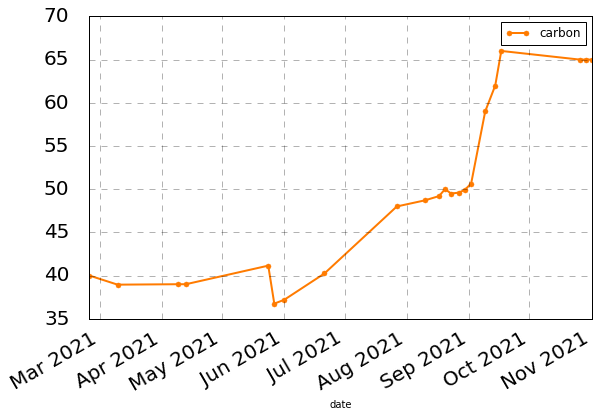

In [434]:
philCarbon.set_index('date').plot(marker='.',figsize=[9,6])

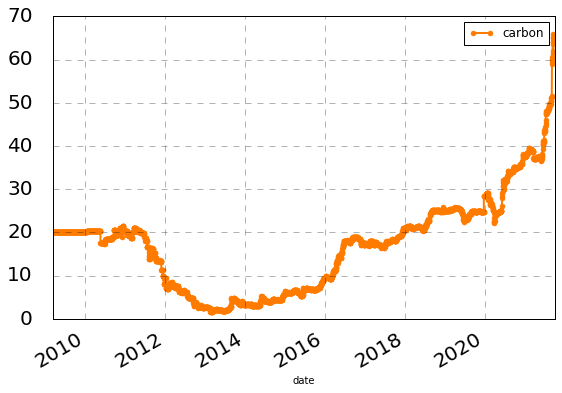

In [435]:
carbonPrice.set_index('date').plot(marker='.',figsize=[9,6])

In [436]:
carbonPrice=carbonPrice[carbonPrice.date<philCarbon.date.min()]

In [437]:
carbonPrice.tail()

,date,carbon
5891,2021-02-17,39.2
5892,2021-02-18,39.2
5893,2021-02-19,39.2
5896,2021-02-22,39.3
5897,2021-02-23,39.2


In [438]:
philCarbon.head()

,date,carbon
114,2021-02-24,40.00
128,2021-03-10,38.95
158,2021-04-09,39.00
162,2021-04-13,39.00
203,2021-05-24,41.15


In [439]:
carbonPrice = pd.concat([carbonPrice, philCarbon]).set_index('date')
carbonPrice.head()
# .plot(marker='.',figsize=[9,6])

,carbon
date,
2009-03-09,20.0
2009-03-10,20.0
2009-03-11,20.0
2009-03-12,20.0
2009-03-13,20.0


In [440]:
carbonPrice.tail()

,carbon
date,
2021-09-14,62.0000
2021-09-17,66.0000
2021-10-26,65.0000
2021-10-29,65.0000
2021-11-01,65.0003


In [441]:
dateIndex=pd.DataFrame(index=pd.date_range(start='1/1/2010', end='31/12/2021'))
dateIndex.index.set_names('date', inplace=True)
dateIndex.head()

""
date
2010-01-01
2010-01-02
2010-01-03
2010-01-04
2010-01-05


In [442]:
carbonPrice=carbonPrice.join(dateIndex,how='outer')
carbonPrice.fillna(method='ffill',inplace=True)

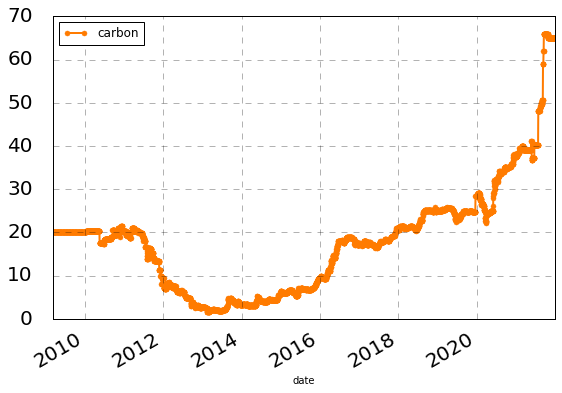

In [443]:
carbonPrice.plot(marker='.',figsize=[9,6])

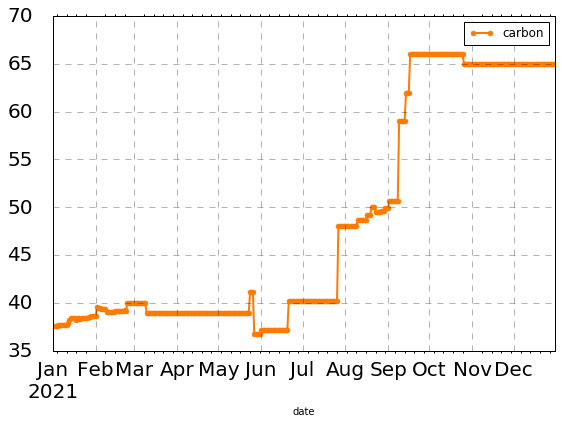

In [444]:
carbonPrice[carbonPrice.index.map(lambda x: x.year==2021)].plot(marker='.',figsize=[9,6])

In [445]:
# carbonPrice[carbonPrice.index.map(lambda x: x.year==2021)].to_csv(carbonPath+'carbonPrice.csv')
carbonPrice.to_csv(carbonPath+'carbonPrice.csv')

In [446]:
# # Alternative data source - maybe not updated as regularly? 
# # From https://github.com/theecanmole/nzu
# carbonPrice = pd.read_csv(inputPath+'nzu-weekly-prices-data.csv',usecols=[0,1],parse_dates=[0],dayfirst=True)
# carbonPrice.rename(columns={'price':'carbon'},inplace=True)

In [447]:
# carbonPrice[carbonPrice.date.dt.year==2021].set_index('date').plot(marker='.',figsize=[15,10])

In [448]:
# carbonPriceDaily=carbonPrice.set_index('date').groupby('date').mean()

In [449]:
carbonPriceDaily=carbonPrice.copy()

In [450]:
carbonPriceDaily.tail()

,carbon
date,
2021-12-27,65.0003
2021-12-28,65.0003
2021-12-29,65.0003
2021-12-30,65.0003
2021-12-31,65.0003


In [451]:
# Convert to monthly 
carbonPrice.reset_index(inplace=True)
carbonPrice['date'] = carbonPrice.date.map(lambda x: pd.Period(x, freq='M').to_timestamp())

In [452]:
carbonPrice.head()

,date,carbon
0,2009-03-01,20.0
1,2009-03-01,20.0
2,2009-03-01,20.0
3,2009-03-01,20.0
4,2009-03-01,20.0


In [453]:
carbonPrice.set_index('date',inplace=True)
carbonPrice.sort_index(inplace=True)
carbonPrice=carbonPrice.groupby('date').mean()

In [454]:
carbonPrice.head()

,carbon
date,
2009-03-01,20.0
2009-04-01,20.0
2009-05-01,20.0
2009-06-01,20.0
2009-07-01,20.0


In [455]:
carbonPrice.tail()

,carbon
date,
2021-08-01,48.944223
2021-09-01,60.316880
2021-10-01,65.806452
2021-11-01,65.000300
2021-12-01,65.000300


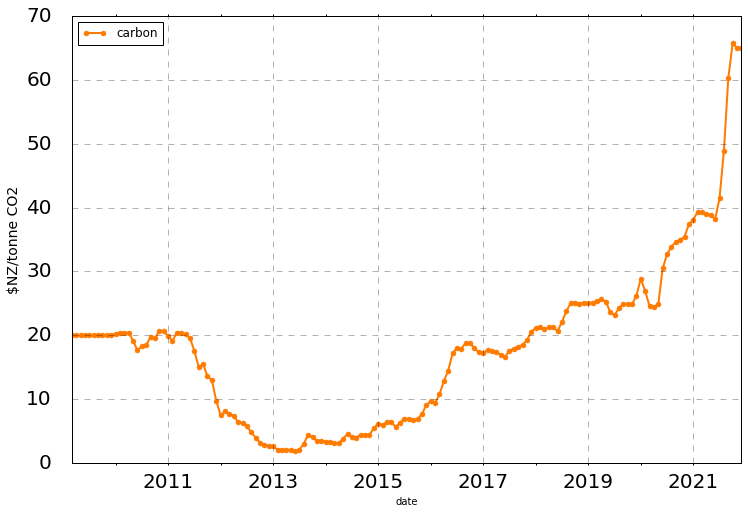

In [456]:
carbonPrice.plot(figsize=[12,8],marker='.')
ylabel('$NZ/tonne CO2', fontsize=14)

In [457]:
#avg carbon prices
print(carbonPrice['2010/1/1':'2018/9/30']['carbon'].mean(),
     carbonPrice['2019/1/1':'2019/12/31']['carbon'].mean(),
     carbonPrice['2020/1/1':'2020/12/31']['carbon'].mean(),
     carbonPrice['2021/1/1':'2021/6/30']['carbon'].mean())



12.026494620124652 24.86396646185356 30.753843746137676 38.80005576036867


## save file of Huntly carbon price in $/GJ

In [458]:
params=pd.read_excel('/media/usb/notebooks/Roger/Roger_Work/References/Thermal SRMC calcs.xlsx', 
                     index_col=[0], usecols=[0,1,2,4,9], nrows=9)
params

,FUEL,Heat Rate (GJ/MWh),Emission Factor (t CO2/TJ),Variable O&M Cost ($/MWh)
GENERATOR,,,,
Huntly e3p U5,gas,7.400,53.97,5.2
TCC CCGT,gas,7.400,53.97,5.2
"Huntly Rankine U1,2,4 coal",coal,10.900,92.18,11.6
"Huntly Rankine U1,2,4 gas",gas,10.900,53.97,9.6
SFD OCGT,gas,8.907,53.97,9.4
McKee OCGT,gas,10.525,53.97,9.4
Junction Rd OCGT,gas,10.525,53.97,9.4
HLY U6 OCGT,gas,10.525,53.97,9.7
Whirinaki OCGT,diesel,10.906,73.48,11.6


In [459]:
#use Huntly 
params_huntly = params[params.index=='HLY U6 OCGT']
params_huntly

,FUEL,Heat Rate (GJ/MWh),Emission Factor (t CO2/TJ),Variable O&M Cost ($/MWh)
GENERATOR,,,,
HLY U6 OCGT,gas,10.525,53.97,9.7


In [460]:
params_huntly=params_huntly.to_dict('index')
params_huntly

{'HLY U6 OCGT': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 10.525,
  'Variable O&M Cost ($/MWh)': 9.7}}

In [461]:
params_huntly['HLY U6 OCGT']['Emission Factor (t CO2/TJ)']

53.97

In [462]:
carbonPrice['carbon_$/GJ'] = (params_huntly['HLY U6 OCGT']['Emission Factor (t CO2/TJ)']/1000)*carbonPrice.carbon
carbonPrice.head()

,carbon,carbon_$/GJ
date,,
2009-03-01,20.0,1.0794
2009-04-01,20.0,1.0794
2009-05-01,20.0,1.0794
2009-06-01,20.0,1.0794
2009-07-01,20.0,1.0794


In [463]:
carbonPrice.tail()

,carbon,carbon_$/GJ
date,,
2021-08-01,48.944223,2.641520
2021-09-01,60.316880,3.255302
2021-10-01,65.806452,3.551574
2021-11-01,65.000300,3.508066
2021-12-01,65.000300,3.508066


In [464]:
import pyarrow as pa
import pyarrow.parquet as pq
carbonPrice_table = pa.Table.from_pandas(carbonPrice)
pq.write_table(carbonPrice_table, "/media/usb/notebooks/Julia/20192020_review/carbonPrice.parquet")

## save file of Stratford carbon price in $/GJ

In [465]:
#use Stratford 
params_stratford = params[params.index=='SFD OCGT']
params_stratford

,FUEL,Heat Rate (GJ/MWh),Emission Factor (t CO2/TJ),Variable O&M Cost ($/MWh)
GENERATOR,,,,
SFD OCGT,gas,8.907,53.97,9.4


In [466]:
params_stratford=params_stratford.to_dict('index')
params_stratford

{'SFD OCGT': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 8.907,
  'Variable O&M Cost ($/MWh)': 9.4}}

In [467]:
params_stratford['SFD OCGT']['Emission Factor (t CO2/TJ)']

53.97

In [468]:
carbonPrice['carbon_$/GJ'] = (params_stratford['SFD OCGT']['Emission Factor (t CO2/TJ)']/1000)*carbonPrice.carbon
carbonPrice.head()

,carbon,carbon_$/GJ
date,,
2009-03-01,20.0,1.0794
2009-04-01,20.0,1.0794
2009-05-01,20.0,1.0794
2009-06-01,20.0,1.0794
2009-07-01,20.0,1.0794


In [469]:
import pyarrow as pa
import pyarrow.parquet as pq
carbonPrice_table = pa.Table.from_pandas(carbonPrice)
pq.write_table(carbonPrice_table, "/media/usb/notebooks/Julia/20192020_review/carbonPrice_stratford.parquet")

### join

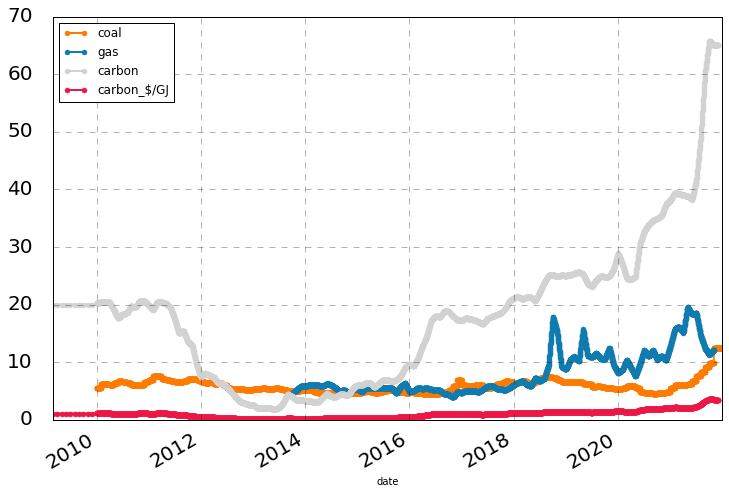

In [470]:
prices=coalPrice.join(gasPrice, how='outer').join(carbonPrice, how='outer')
prices.interpolate(inplace=True,limit_area='inside')
prices.plot(figsize=[12,8],marker='.')
# ylabel('$NZ/GJ', fontsize=14)

In [471]:
prices.head()

,coal,gas,carbon,carbon_$/GJ
date,,,,
2009-03-01,NaN,NaN,20.0,1.0794
2009-04-01,NaN,NaN,20.0,1.0794
2009-05-01,NaN,NaN,20.0,1.0794
2009-06-01,NaN,NaN,20.0,1.0794
2009-07-01,NaN,NaN,20.0,1.0794


In [472]:
prices.tail()

,coal,gas,carbon,carbon_$/GJ
date,,,,
2021-12-27,12.494,NaN,NaN,NaN
2021-12-28,12.494,NaN,NaN,NaN
2021-12-29,12.494,NaN,NaN,NaN
2021-12-30,12.494,NaN,NaN,NaN
2021-12-31,12.494,NaN,NaN,NaN


In [473]:
prices.fillna(method='ffill',inplace=True)

In [474]:
prices.tail()

,coal,gas,carbon,carbon_$/GJ
date,,,,
2021-12-27,12.494,12.1712,65.0003,3.508066
2021-12-28,12.494,12.1712,65.0003,3.508066
2021-12-29,12.494,12.1712,65.0003,3.508066
2021-12-30,12.494,12.1712,65.0003,3.508066
2021-12-31,12.494,12.1712,65.0003,3.508066


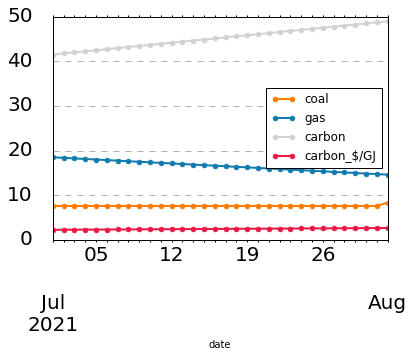

In [513]:
prices['2021/7/1':'2021/8/1'].plot(marker='.')

In [475]:
params=pd.read_excel('/media/usb/notebooks/Roger/Roger_Work/References/Thermal SRMC calcs.xlsx', 
                     index_col=[0], usecols=[0,1,2,4,9], nrows=9)
params

,FUEL,Heat Rate (GJ/MWh),Emission Factor (t CO2/TJ),Variable O&M Cost ($/MWh)
GENERATOR,,,,
Huntly e3p U5,gas,7.400,53.97,5.2
TCC CCGT,gas,7.400,53.97,5.2
"Huntly Rankine U1,2,4 coal",coal,10.900,92.18,11.6
"Huntly Rankine U1,2,4 gas",gas,10.900,53.97,9.6
SFD OCGT,gas,8.907,53.97,9.4
McKee OCGT,gas,10.525,53.97,9.4
Junction Rd OCGT,gas,10.525,53.97,9.4
HLY U6 OCGT,gas,10.525,53.97,9.7
Whirinaki OCGT,diesel,10.906,73.48,11.6


In [476]:
stations=params.index.values.tolist()
stations

['Huntly e3p U5',
 'TCC CCGT',
 'Huntly Rankine U1,2,4 coal',
 'Huntly Rankine U1,2,4 gas',
 'SFD OCGT',
 'McKee OCGT',
 'Junction Rd OCGT',
 'HLY U6 OCGT',
 'Whirinaki OCGT']

In [477]:
params=params.to_dict('index')
params

{'HLY U6 OCGT': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 10.525,
  'Variable O&M Cost ($/MWh)': 9.7},
 'Huntly Rankine U1,2,4 coal': {'Emission Factor (t CO2/TJ)': 92.18,
  'FUEL': 'coal',
  'Heat Rate (GJ/MWh)': 10.9,
  'Variable O&M Cost ($/MWh)': 11.6},
 'Huntly Rankine U1,2,4 gas': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 10.9,
  'Variable O&M Cost ($/MWh)': 9.6},
 'Huntly e3p U5': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 7.4,
  'Variable O&M Cost ($/MWh)': 5.2},
 'Junction Rd OCGT': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 10.525,
  'Variable O&M Cost ($/MWh)': 9.4},
 'McKee OCGT': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 10.525,
  'Variable O&M Cost ($/MWh)': 9.4},
 'SFD OCGT': {'Emission Factor (t CO2/TJ)': 53.97,
  'FUEL': 'gas',
  'Heat Rate (GJ/MWh)': 8.907,
  'Variable O&M Cost ($/MWh)': 

In [478]:
params['Huntly e3p U5']['Heat Rate (GJ/MWh)']

7.4

In [479]:
SRMC=prices.copy()

for stn in stations:
    try:
        fuel=params[stn]['FUEL']
        SRMC[fuel] # go to except block if doesn't exist 
        SRMC[stn]=params[stn]['Variable O&M Cost ($/MWh)']
        if (params[stn]['FUEL']=='gas') and gasPriceIncludesCarbon:
            SRMC[stn]=SRMC[stn]+params[stn]['Heat Rate (GJ/MWh)']*SRMC[fuel]
        else:
            SRMC[stn]=SRMC[stn]+params[stn]['Heat Rate (GJ/MWh)']*\
                                            (SRMC[fuel] + params[stn]['Emission Factor (t CO2/TJ)']/1000*SRMC.carbon)
    except:
        continue
        
SRMC=SRMC.iloc[:,3:]
SRMC.tail()

,carbon_$/GJ,Huntly e3p U5,TCC CCGT,"Huntly Rankine U1,2,4 coal","Huntly Rankine U1,2,4 gas",SFD OCGT,McKee OCGT,Junction Rd OCGT,HLY U6 OCGT
date,,,,,,,,,
2021-12-27,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-28,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-29,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-30,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-31,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188


In [480]:
SRMC=prices.copy()

for stn in stations:
    try:
        fuel=params[stn]['FUEL']
        SRMC[fuel] # go to except block if doesn't exist 
        SRMC[stn]=params[stn]['Variable O&M Cost ($/MWh)']
        if (params[stn]['FUEL']=='gas') and gasPriceIncludesCarbon:
            SRMC[stn]=SRMC[stn]+params[stn]['Heat Rate (GJ/MWh)']*SRMC[fuel]
        else:
            SRMC[stn]=SRMC[stn]+params[stn]['Heat Rate (GJ/MWh)']*\
                                            (SRMC[fuel] + params[stn]['Emission Factor (t CO2/TJ)']/1000*SRMC.carbon)
    except:
        continue
        
SRMC=SRMC.iloc[:,3:]
SRMC.tail()

,carbon_$/GJ,Huntly e3p U5,TCC CCGT,"Huntly Rankine U1,2,4 coal","Huntly Rankine U1,2,4 gas",SFD OCGT,McKee OCGT,Junction Rd OCGT,HLY U6 OCGT
date,,,,,,,,,
2021-12-27,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-28,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-29,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-30,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188
2021-12-31,3.508066,95.26688,95.26688,213.094431,142.26608,117.808878,137.50188,137.50188,137.80188


In [481]:
SRMC.head(100)

,carbon_$/GJ,Huntly e3p U5,TCC CCGT,"Huntly Rankine U1,2,4 coal","Huntly Rankine U1,2,4 gas",SFD OCGT,McKee OCGT,Junction Rd OCGT,HLY U6 OCGT
date,,,,,,,,,
2009-03-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-05-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-08-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-11-01,1.079400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [482]:
#save parquet file
import pyarrow as pa
import pyarrow.parquet as pq
SRMC_table = pa.Table.from_pandas(SRMC)
pq.write_table(SRMC_table, "/media/usb/notebooks/Julia/20192020_review/SRMC.parquet")

In [483]:
size=int(np.asarray(SRMC.shape)[0]/2)

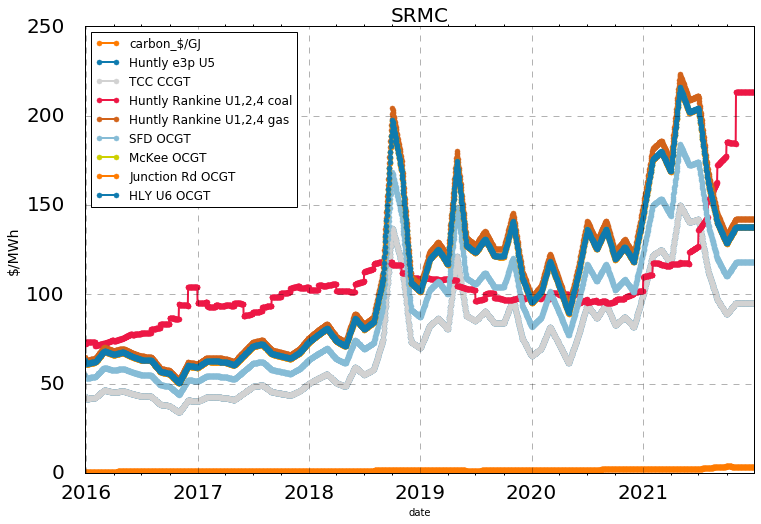

In [484]:
ax=SRMC.tail(size).plot(figsize=[12,8],marker='.')
ylabel('$/MWh', fontsize=14)
ax.set_title('SRMC', fontsize=20)

In [485]:
# SRMC.iloc[-3,:].sort_values()

In [486]:
SRMC = SRMC[SRMC.index.year >= 2020]
path='/media/usb/notebooks/Juliaa/HsoTc/'

In [487]:
import matplotlib.dates as mdates
import matplotlib.ticker as tkr

ea_p=ea.ea_p
ea_s=ea.ea_s
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.major.width'] = 0
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['font.weight'] = 500
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='20'

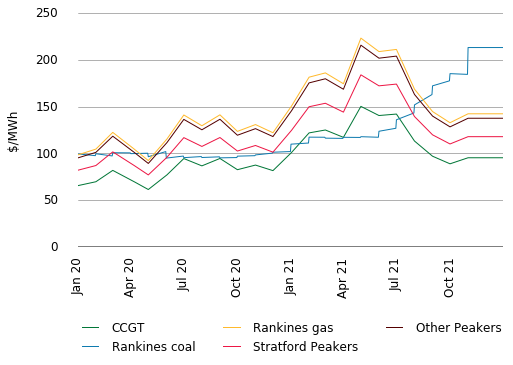

In [488]:
plt.rcParams['xtick.major.size'] = 5
ea_p=ea.ea_p
ea_s=ea.ea_s
fig = plt.figure(1,figsize=[cm2inch(20),cm2inch(15)])
ax=fig.add_subplot(111)

lns1=ax.plot(SRMC.index, SRMC['TCC CCGT'], label= 'CCGT', 
                              lw=1, marker='None', color=ea_s['gr1'])
lns2=ax.plot(SRMC.index, SRMC['Huntly Rankine U1,2,4 coal'], label= 'Rankines coal', 
                              lw=1, marker='None', color=ea_p['bl1'])
lns3=ax.plot(SRMC.index, SRMC['Huntly Rankine U1,2,4 gas'], label= 'Rankines gas', 
                              lw=1, marker='None', color=ea_p['yl1'])
lns4=ax.plot(SRMC.index, SRMC['SFD OCGT'], label= 'Stratford Peakers', 
                              lw=1, marker='None', color=ea_p['rd1'])
lns5=ax.plot(SRMC.index, SRMC['McKee OCGT'], label= 'Other Peakers', 
                              lw=1, marker='None', color=ea_p['br1'])
 
 
ylabel('$/MWh', fontsize=12)
 

fig.subplots_adjust(left=0.2)
fig.subplots_adjust(right=0.95)
fig.subplots_adjust(bottom=0.35)

ax.grid(b=True, which='major', color='k', linestyle='-', axis='y',alpha=0.6, clip_on=True , marker=None )
ax.grid(b=False, axis='x', which='both')
#ax.set_title('Daily and weekly average spot prices \u2014 Otahuhu and Benmore', fontsize=12)

ax.set_axisbelow(True)
ax.set_frame_on(False)
ax.xaxis.tick_bottom()

#ax.axhline(45,  lw=1, alpha=0.5, color='k')
ax.axhline(0,  lw=2, alpha=0.5, color='k')


ax.set_ylabel(r"$/MWh", fontsize=12,  family='arial', labelpad=15)

#p = plt.axvspan(736951., 736999, alpha=0.5, facecolor=(ea_p['bl2']))


def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s
y_format = tkr.FuncFormatter(func)  # make formatter
ax.yaxis.set_major_formatter(y_format) 


yearsFmt = mdates.DateFormatter('%b %y')
ax.xaxis.set_major_formatter(yearsFmt)
plt.setp(ax.get_yticklabels(),  fontsize=12)
plt.setp(ax.get_xticklabels(),  fontsize=12, rotation=90)


#plt.setp(ax2.get_yticklabels(),  fontsize=12)
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
legend1=ax.legend(lns, labs, loc=3, bbox_to_anchor=(-0.025, -0.2 - 0.3),fancybox=False, shadow=False, frameon=False ,ncol=3, fontsize=12)
# q = Rectangle((0, 0), 1, 1, fc=ea_s['pp1'], ec='none', alpha=0.1)
# p = Rectangle((0, 0), 1, 1, fc=ea_s['or1'], ec='none', alpha=0.1)

# pyplot.legend([q, p], ["level 4", "level 3"], loc=3, bbox_to_anchor=(-0.025, -0.55),fancybox=False, shadow=False, frameon=False ,ncol=4, fontsize=12)
# pyplot.gca().add_artist(legend1)

pylab.savefig(path +'pics/SRMC_thermal.png', dpi=300, transparent=True, bbox_inches='tight')


### Huntly Rankine Coal Price Components (transport from port to HLY is included in fuel price)

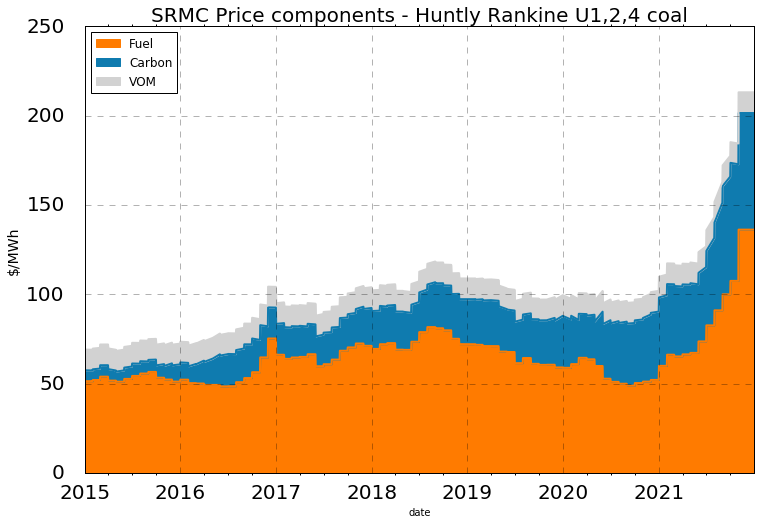

In [489]:
SRMCtemp=prices.copy()

for stn in ['Huntly Rankine U1,2,4 coal']:
    try:
#         print(stn)
        fuel=params[stn]['FUEL']
#         print(fuel)
        SRMCtemp[fuel] # go to except block if doesn't exist 
        SRMCtemp[stn]=params[stn]['Variable O&M Cost ($/MWh)']
        if (params[stn]['FUEL']=='gas') and gasPriceIncludesCarbon:
            SRMCtemp[stn]=SRMCtemp[stn]+params[stn]['Heat Rate (GJ/MWh)']*SRMCtemp[fuel]
        else:
            SRMCtemp['Fuel']=params[stn]['Heat Rate (GJ/MWh)']*SRMCtemp[fuel]
            SRMCtemp['Carbon']=params[stn]['Heat Rate (GJ/MWh)']*(params[stn]['Emission Factor (t CO2/TJ)']/1000*SRMCtemp.carbon)
            SRMCtemp['VOM']=SRMCtemp[stn]
    except:
        continue
        
SRMCtemp=SRMCtemp['2015/1/1':].iloc[:,-3:]
# SRMCtemp.tail()
ax=SRMCtemp.plot(kind='area',stacked=True,figsize=[12,8])
ylabel('$/MWh', fontsize=14)
ax.set_title('SRMC Price components - '+stn, fontsize=20)

### Daily Gas excl Carbon, Coal excl Carbon, Carbon prices for regression

In [490]:
gasPriceDaily.tail()

,gas
date,
2021-10-28,11.1731
2021-10-29,11.1042
2021-10-30,10.8951
2021-10-31,10.5844
2021-11-01,12.1712


In [491]:
prices.tail()

,coal,gas,carbon,carbon_$/GJ
date,,,,
2021-12-27,12.494,12.1712,65.0003,3.508066
2021-12-28,12.494,12.1712,65.0003,3.508066
2021-12-29,12.494,12.1712,65.0003,3.508066
2021-12-30,12.494,12.1712,65.0003,3.508066
2021-12-31,12.494,12.1712,65.0003,3.508066


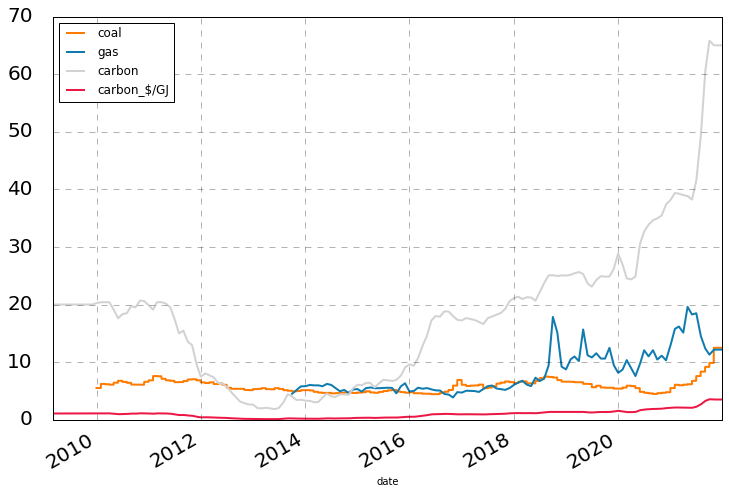

In [495]:
prices.plot(figsize=[12,8])

In [504]:
doasaPrices=prices.copy()

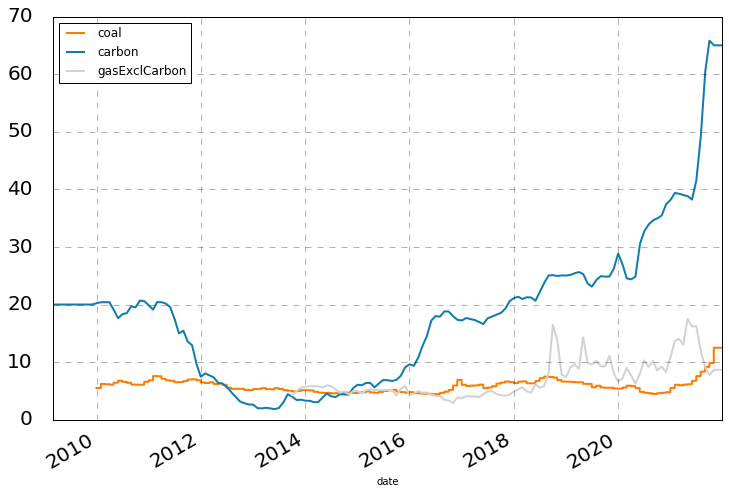

In [505]:
for stn in ['Huntly e3p U5']:
    doasaPrices['gasExclCarbon']=(doasaPrices.gas - params[stn]['Emission Factor (t CO2/TJ)']/1000*doasaPrices.carbon)        
doasaPrices.drop(columns=['gas','carbon_$/GJ'],inplace=True)
doasaPrices.plot(figsize=[12,8])

In [506]:
doasaPrices=doasaPrices['2010-01-01':]

In [507]:
doasaPrices.to_csv(carbonPath+'doasaPrices.csv')

In [492]:
# AntheaPrices=gasPriceDaily.join(carbonPriceDaily).join(coalPrice, how='outer').fillna(method='ffill')
AntheaPrices=gasPriceDaily.join(carbonPriceDaily).join(coalPrice, how='outer').interpolate()#limit_area='inside')

# prices.interpolate(inplace=True,limit_area='inside')

for stn in ['Huntly e3p U5']:
    AntheaPrices['gasExclCarbon']=(AntheaPrices.gas - params[stn]['Emission Factor (t CO2/TJ)']/1000*AntheaPrices.carbon)
        
AntheaPrices.drop(columns='gas',inplace=True)

In [493]:
1=1

SyntaxError: can't assign to literal (<ipython-input-493-c59fb5224dc0>, line 1)

In [ ]:
AntheaPrices=AntheaPrices['2014-01-01':]

In [ ]:
AntheaPrices.tail(30)

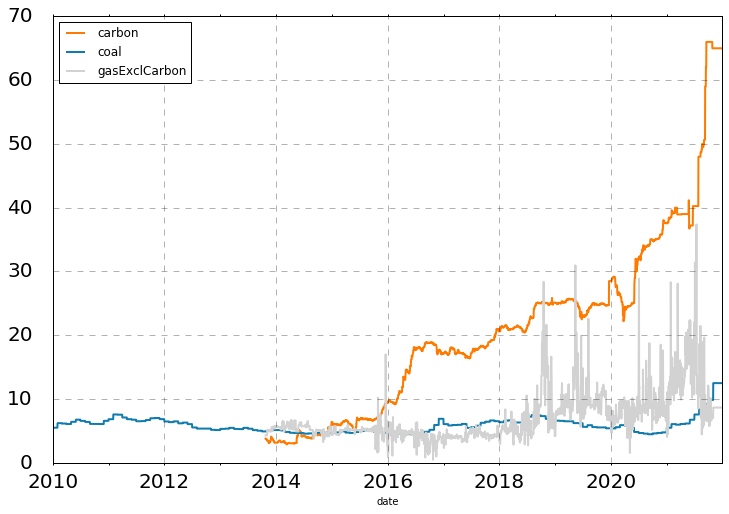

In [494]:
AntheaPrices.plot(figsize=[12,8])

In [ ]:
AntheaPrices.to_csv('AntheaPrices.csv')

In [ ]:
AntheaPrices.to_parquet('AntheaPrices.parquet')

In [ ]:
pd.read_parquet("AntheaPrices.parquet").tail()

In [ ]:
#this shows how much memory the larger variables are taking up
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))